# Fully-connected neural network retrieval

This notebook implements a precipitation retrieval for the IPWG SatRain dataset based on a fully-connected neural network implemented using [PyTorch](https://pytorch.org/) and [Lightning](https://lightning.ai/docs/pytorch/stable/).

> **NOTE**: This notebook can be run on Google Colab. To install the necessary dependencies uncomment the following cell and execute it.

In [1]:
#!pip install satrain[complete]@git+https://github.com/ipwgml/satrain

## The training data

The ``satrain`` package provides dataset classes that take care of downloading, preprocessing and loading of the SatRain training data. The ``satrain.pytorch.dataset.SatRainTabular`` class implements the PyTorch dataset interface for the SatRain data in tabular format, i.e., for pixel-based retrievals.

The retrieval input data to load and the quality criteria for the reference surface precipitation data can be configured using the ``InputConfig`` classes from the ``satrain.input`` module and the ``TargetConfig`` class from the ``ipgml.target`` module, respectively.

For this example notebook we use only GMI observations as input. We configure the ``GMI`` input to not include the earth-incidence angles. Moreover, enable minimum-maximum normalization of the input and replace NAN values with -1.5.

> **NOTE**: Both input and reference data in the SatRain dataset may contain NANs because observations or precipitation estimates may be missing or of insufficient quality. It is up to the user to handle those.

We choose the ``on_swath`` geometry for the retrieval, which is a natural choice for pixel-based retrievals. We also set up batching in the dataset, which is more efficient for tabular data than leaving it to the PyTorch data loader to perform the batching.

In [2]:
from satrain.input import GMI, Ancillary, Geo, GeoIR
from satrain.target import TargetConfig

inputs = [GMI(normalize="minmax", nan=-1.5, include_angles=False)]
target_config = TargetConfig(min_rqi=0.5)
geometry = "on_swath"
batch_size = 1024

With these settings, we can instantiate the training dataset. By setting ``stack=True`` we also tell the retrieval to stack all input tensors instead of loading the input data as a dictionary.

> **Note**: The current implementation of the dataset loads all training data into memory upon instantiation. Therefore, executing the cell below may take some time.

In [3]:
from torch.utils.data import DataLoader
from satrain.pytorch.datasets import SatRainTabular

training_data = SatRainTabular(
    base_sensor="gmi",
    geometry=geometry,
    split="training",
    subset="s",
    retrieval_input=inputs,
    batch_size=batch_size,
    target_config=target_config,
    stack=True,
    download=True,
)
training_loader = DataLoader(training_data, shuffle=True, batch_size=None, num_workers=1)

[08/29/25 11:31:23] INFO     INFO:satrain.pytorch.datasets:Loading training data from 5484 training  ]8;id=362173;file:///home/simon/src/satrain/src/satrain/pytorch/datasets.py\datasets.py]8;;\:]8;id=137849;file:///home/simon/src/satrain/src/satrain/pytorch/datasets.py#170\170]8;;\
                             scenes.                                                                               

We also create a validation loader with the same configuration.

In [4]:
validation_data = SatRainTabular(
    base_sensor="gmi",
    geometry="on_swath",
    split="validation",
    subset="s",
    retrieval_input=inputs,
    batch_size=batch_size,
    target_config=target_config,
    stack=True,
    download=True,
    shuffle=False
)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=None)

[08/29/25 11:32:05] INFO     INFO:satrain.pytorch.datasets:Loading validation data from 838 training ]8;id=942675;file:///home/simon/src/satrain/src/satrain/pytorch/datasets.py\datasets.py]8;;\:]8;id=738552;file:///home/simon/src/satrain/src/satrain/pytorch/datasets.py#170\170]8;;\
                             scenes.                                                                               

## Defining the neural network

In [5]:
from typing import Any, Callable, Dict

import torch
from torch import optim
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
import lightning as L

OUTPUTS = [
    "surface_precip",
    "probability_of_precip",
    "probability_of_heavy_precip"
]

N_EPOCHS = 20

class MLP(L.LightningModule):
    """
    Lightning module implementing a multi-layer perceptron (MLP) for retrieving precipitation from satellite
    observations.
    """
    def __init__(
        self,
        n_input_features: int,
        n_hidden_layers: int,
        n_neurons: int,
        activation_fn: Callable[[], nn.Module] = nn.GELU,
        normalization_layer: Callable[[int], nn.Module] = nn.LayerNorm,
        n_epochs: int = N_EPOCHS
    ):
        """
        Args:
            n_input_features: The number of features in the input
            n_hidden_layers: The number of hidden layers in the MLP
            n_neurons: The number of neurons in the hidden layers
            activation_fn: A callable to create activation function layers.
            normalization_layer: A callable to create normalization layers.
            n_epochs: The numebr of epochs the model will be trained for.
        """
        super().__init__()
        blocks = [
            nn.Linear(n_input_features, n_neurons),
            normalization_layer(n_neurons),
            activation_fn(),
        ]
        for _ in range(n_hidden_layers):
            blocks += [
                nn.Linear(n_neurons, n_neurons),
                normalization_layer(n_neurons),
                activation_fn(),
            ]
        self.body = nn.Sequential(*blocks)

        heads = {}
        for output in OUTPUTS:
            heads[output] =  nn.Sequential(
                nn.Linear(n_neurons, n_neurons),
                normalization_layer(n_neurons),
                activation_fn(),
                nn.Linear(n_neurons, 1)
            )
        self.heads = nn.ModuleDict(heads)
        self.n_epochs = N_EPOCHS

    def forward(self, retrieval_input: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward retrieval input through network and produce dictionary with predictions.

        Args:
            retrieval_input: The retrieval input as a single torch.Tensor.

        Return:
            A dictionary containing the predictions for 'surface_precip', 'probability_of_precip',
            and 'probability_of_heavy_precip'.
        """
        y = self.body(retrieval_input)
        return {
            name: module(y) for name, module in self.heads.items()
        }
        
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        """
        Calculates the loss-function gradients for the MLP.

        The loss is calculated as the sum of the MSE for 'surface_precip' and the binary cross-entropy loss
        for precipitation detection and heavy precipitation detection.

        Args:
            batch: A tuple containing the training data loaded from the data loader.
            batch_idx: The index of the batch in the current epoch. Not used.

        Return:
            A scalar torch.Tensor containing the total loss.
        """
        inpt, target = batch
        pred = self(inpt)

        surface_precip = target["surface_precip"]
        precip_mask = target["precip_mask"]
        heavy_precip_mask = target["heavy_precip_mask"]
        surface_precip_pred = pred["surface_precip"]
        pop = pred["probability_of_precip"]
        pohp = pred["probability_of_heavy_precip"]
        
        # MSE loss for QPE
        loss_quant = ((surface_precip_pred[..., 0] - surface_precip) ** 2).mean()
        # BCE loss for detection targets
        loss_detect = binary_cross_entropy_with_logits(pop[..., 0], precip_mask)
        loss_detect_heavy = binary_cross_entropy_with_logits(pohp[..., 0], heavy_precip_mask)
        tot_loss =  loss_quant + loss_detect + loss_detect_heavy
        return tot_loss

    def validation_step(self, batch, batch_idx) -> None:
        """
        Calculates the loss-function values on validation data.

        Args:
            batch: A tuple containing the training data loaded from the data loader.
            batch_idx: The index of the batch in the current epoch. Not used.
        """
        inpt, target = batch
        pred = self(inpt)

        surface_precip = target["surface_precip"]
        precip_mask = target["precip_mask"]
        heavy_precip_mask = target["heavy_precip_mask"]
        surface_precip_pred = pred["surface_precip"]
        pop = pred["probability_of_precip"]
        pohp = pred["probability_of_heavy_precip"]
        
        # MSE loss for QPE
        loss_quant = ((surface_precip_pred[..., 0] - surface_precip) ** 2).mean()
        # BCE loss for detection targets
        loss_detect = binary_cross_entropy_with_logits(pop[..., 0], precip_mask)
        loss_detect_heavy = binary_cross_entropy_with_logits(pohp[..., 0], heavy_precip_mask)
        tot_loss =  loss_quant + loss_detect + loss_detect_heavy

        opt = self.optimizers()
        learning_rate = opt.param_groups[0]['lr']
        
        self.log_dict(
            {
                "val_loss": loss_quant + loss_detect + loss_detect_heavy,
                "val_loss_quant": loss_quant,
                "val_loss_detect": loss_detect,
                "val_loss_detect_heavy": loss_detect_heavy,
                "learning_rate": learning_rate
            },
            on_epoch=True,
            prog_bar=True
        )
    
    def configure_optimizers(self) -> Dict[str, Any]:
        """
        We use the Adam optimizer with a cosine annealing learning rate schedule.
        """
        optimizer = optim.Adam(self.parameters(), lr=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler
        }

In [6]:
from satrain.input import calculate_input_features
input_features = calculate_input_features(inputs, stack=True)
mlp = MLP(n_input_features=input_features, n_hidden_layers=4, n_neurons=256)

## Running the training

In [7]:
from lightning.pytorch.callbacks import TQDMProgressBar

trainer = L.Trainer(
    max_epochs=N_EPOCHS,
    callbacks=[TQDMProgressBar(refresh_rate=100)]
)
trainer.fit(model=mlp, train_dataloaders=training_loader, val_dataloaders=validation_loader)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


[08/29/25 11:32:14] INFO     INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of  ]8;id=199257;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=440031;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             2 GPUs because it is running inside an interactive / notebook                         
                             environment. You may try to set `Trainer(devices=2)` but please note                  
                             that multi-GPU inside interactive / notebook environments is                          
                             considered experimental and unstable. Your mileage may vary.                          

INFO: GPU available: True (cuda), used: True


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), ]8;id=45088;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=13927;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             used: True                                                                            

INFO: TPU available: False, using: 0 TPU cores


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:TPU available: False,       ]8;id=489429;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=381475;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 TPU cores                                                                    

INFO: HPU available: False, using: 0 HPUs


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:HPU available: False,       ]8;id=535817;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=992363;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             using: 0 HPUs                                                                         

INFO: You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


                    INFO     INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ]8;id=245100;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=95369;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly                 
                             utilize them, you should set                                                          
                             `torch.set_float32_matmul_precision('medium' | 'high')` which will                    
                             trade-off precision for performance. For more details, read                           
                             https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_pre                
                             cision.html#torch.set_float32_matmul_precision                                        

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


                    INFO     INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 -                    ]8;id=740160;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=418853;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\
                             CUDA_VISIBLE_DEVICES: [0,1]                                                           

INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | body  | Sequential | 269 K  | train
1 | heads | ModuleDict | 199 K  | train
---------------------------------------------
468 K     Trainable params
0         Non-trainable params
468 K     Total params
1.876     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


                    INFO     INFO:lightning.pytorch.callbacks.model_summary:                   ]8;id=464023;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=971740;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
                               | Name  | Type       | Params | Mode                                                
                             ---------------------------------------------                                         
                             0 | body  | Sequential | 269 K  | train                                               
                             1 | heads | ModuleDict | 199 K  | train                                               
                             ---------------------------------------------                                         
                             468 K     Trainable params                                                            
                             0         Non-trainable params                                                        
                             468 K     Total params                                                                
                             1.876     Total estimated model params size (MB)                                      
                             32        Modules in train mode                                                       
                             0         Modules in eval mode                                                        

Sanity Checking: |                                                                                            …

/home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


[08/29/25 11:40:20] INFO     INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped:      ]8;id=124252;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=481618;file:///home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             `max_epochs=20` reached.                                                              

## Plotting validation samples

To get an idea of the performance of the model, let's create a scatter plot of retrieved and reference precipitation from the validation datasets.

In [48]:
mlp.to(device="cpu", dtype=torch.float32)

surface_precip = []
surface_precip_ref = []

n_batches = 100
for batch_ind, (x, y) in enumerate(iter(validation_loader)):
    if 100 < batch_ind:
        break
    with torch.no_grad():
        pred = mlp(x)
        surface_precip += [pred["surface_precip"]]
        surface_precip_ref += [y["surface_precip"]]

surface_precip = torch.cat(surface_precip).numpy().ravel()
surface_precip_ref = torch.cat(surface_precip_ref).numpy().ravel()

In [63]:
corr_coef

array([1.        , 0.72714673])

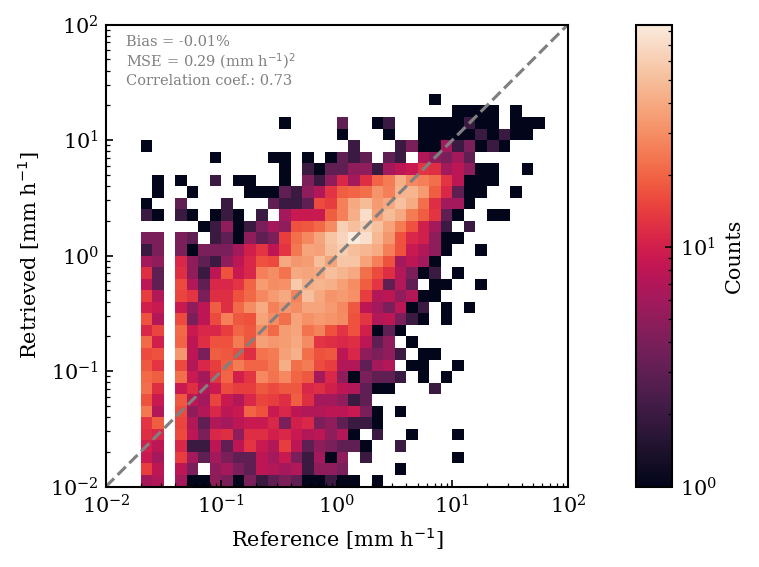

In [73]:
from satrain.plotting import set_style, cmap_tbs
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
set_style()

fig = plt.figure(figsize=(5, 4))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.075])
ax = fig.add_subplot(gs[0, 0])

bins = np.logspace(-2, 2, 41)
scatter = np.histogram2d(surface_precip_ref, surface_precip, bins=bins)[0]
mappable = ax.pcolormesh(bins, bins, scatter.T, norm=LogNorm(), cmap=cmap_tbs)
ax.plot(bins, bins, color="grey", linestyle="--")

ax.set_xlabel("Reference [mm h$^{-1}$]")
ax.set_ylabel("Retrieved [mm h$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect(1.0)

bias = (surface_precip - surface_precip_ref).mean() / surface_precip_ref.mean()
mse = ((surface_precip - surface_precip_ref) ** 2).mean()
corr_coef = np.corrcoef(surface_precip, surface_precip_ref)[0, 1]
ax.text(0.015, 30, f"Bias = {bias:.2f}%\nMSE = {mse:.2} (mm h$^{{-1}}$)$^2$\nCorrelation coef.: {corr_coef:.2f}", fontsize=7, color="grey")

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(mappable, label="Counts", cax=cax)

## Evaluating the retrieval

In oder to evaluate the fully-connected precipitation retrieval, we need a function  to conventional precipitation retrievals, we can use the ``satrain.evaluation.Evaluator``. The evaluates the retrieval using the exact same data used to evaluate [the IMERG](evaluate_imerg.ipynb) and [GPROF](evaluate_gprof.ipynb) retrievals and thus ensures that the results are comparable. To ensure consistency between training and evaluation data, we instantiate the evaluator with the same values for ``geometry`` and ``retrieval_input`` as the training and validation dataset objects.

In [8]:
from satrain.evaluation import Evaluator
evaluator = Evaluator(
    base_sensor="gmi",
    domain="korea",
    geometry=geometry,
    retrieval_input=inputs,
    download=True
)

## The retrieval callback function

Evaluating the MLP using the ``satrain.evaluation.Evaluator`` requires implementing a retrieval callback function that the evaluator can call to obtain the rerieval results for a given collocation scene. The ``satrain.pytorch`` module provides a wrapper class that turns a given Pytorch retrieval into such a callback function. The ``PytorchRetrieval`` class simply takes the data from the evaluator and converts it to ``torch.Tensor`` objects and puts the results back into an ``xarray.Dataset``.

In [13]:
from satrain.pytorch import PytorchRetrieval
mlp_retrieval = PytorchRetrieval(mlp, retrieval_input=inputs, stack=True, device=torch.device("cuda"))

## Case study

/home/simon/miniconda3/envs/satrain/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


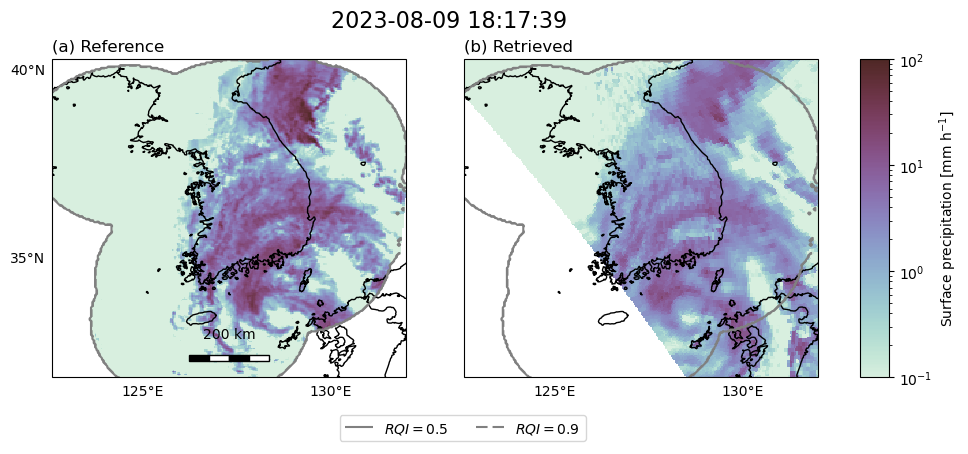

In [14]:
fig = evaluator.plot_retrieval_results(516, mlp_retrieval, input_data_format="tabular", batch_size=1024)

## Evaluation 

In [15]:
evaluator.evaluate(retrieval_fn=mlp_retrieval, input_data_format="tabular", batch_size=4048, n_processes=1)

Output()

## Results

### Precipitation quantification

In [16]:
evaluator.get_precip_quantification_results(name="MLP (GMI)").T

,MLP (GMI),ERA5,GPROF V7 (GMI)
Bias [$\%$],-18.225801,-12.580348,-27.236600
MAE [$mm h^{-1}$],0.138148,0.212744,0.338000
MSE [$(mm h^{-1})^2$],1.622280,2.465700,5.175863
SMAPE$_{0.1}$ [$\%$],78.521371,105.643559,83.221078
Correlation coeff. [],0.691448,0.336344,0.650835
Effective resolution [$^\circ$],0.274387,inf,0.279000


In [17]:
sc = evaluator.precip_quantification_metrics[-1].compute()

### Precipitation detection

In [18]:
evaluator.get_precip_detection_results(name="MLP (GMI)").T

,MLP (GMI),ERA5,GPROF V7 (GMI)
POD [],0.634457,NaN,0.756630
FAR [],0.225415,NaN,0.351667
HSS [],0.753183,NaN,0.574699


### Probabilistic precipitation detection

In [19]:
evaluator.get_prob_precip_detection_results(name="MLP (GMI)").T

,MLP (GMI),ERA5,GPROF V7 (GMI)
AUC [],0.652328,0.0,0.54994


### Heavy precipitation detection

In [20]:
evaluator.get_heavy_precip_detection_results(name="MLP (GMI)").T

,MLP (GMI),ERA5,GPROF V7 (GMI)
POD [],0.086209,NaN,0.758366
FAR [],0.248452,NaN,0.462010
HSS [],0.751445,NaN,0.508161


### Heavy probabilistic precipitation detection

In [21]:
evaluator.get_prob_heavy_precip_detection_results(name="MLP (GMI)").T

,MLP (GMI),ERA5,GPROF V7 (GMI)
AUC [],0.49064,0.0,0.298044
